In [48]:
# Basic packages
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Packages for data preparation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras.models import Sequential
from keras.layers import *

In [2]:
# Parameter indicating the number of words we'll put in the dictionary
NB_WORDS = 10000

# Number of epochs
NB_START_EPOCHS = 4  

# Size of the batches used 
BATCH_SIZE = 32 

# Maximum number of words in a sequence
MAX_LEN = 0 # Will be put later

In [3]:
def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words)

In [4]:
# List to store movie reviews
movie_reviews = []

# List to store review labels
training_labels = []

for label in ['pos','neg']:

    base_path = os.path.join('../Dataset/aclImdb/train/',label)

    for one_file in os.listdir(base_path):
        file_handle = open(os.path.join(base_path,one_file),encoding='utf8')
        movie_reviews.append(file_handle.read())
        file_handle.close()

        if label == 'pos':
            training_labels.append(1)   # 1 is denoting positive review
        else:
            training_labels.append(0)   # 0 is denoting negative review
            
movie_reviews = pd.Series(movie_reviews)

In [5]:
# List to store testing movie reviews
testing_movie_reviews = []

# List to store testing review labels
testing_labels = []

for label in ['pos','neg']:

    base_path = os.path.join('../Dataset/aclImdb/test/',label)

    for one_file in os.listdir(base_path):
        file_handle = open(os.path.join(base_path,one_file),encoding='utf8')
        testing_movie_reviews.append(file_handle.read())
        file_handle.close()

        if label == 'pos':
            testing_labels.append(1)   # 1 is denoting positive review
        else:
            testing_labels.append(0)   # 0 is denoting negative review
            
testing_movie_reviews = pd.Series(movie_reviews)

In [6]:
# These reviews needs to be processed
print(movie_reviews[0])
print('\n')
print('This review is positive and is denoted by {}.'.format({training_labels[0]}))

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!


This review is positive and is denoted by {1}.


In [7]:
# Preprocessing
movie_reviews = movie_reviews.apply(remove_stopwords)
testing_movie_reviews = testing_movie_reviews.apply(remove_stopwords)

In [8]:
# Preprocessed Data
print(movie_reviews[0])
print('\n')
print('This review is positive and is denoted by {}.'.format({training_labels[0]}))

Bromwell High cartoon comedy. It ran time programs school life, "Teachers". My 35 years teaching profession lead believe Bromwell High's satire much closer reality "Teachers". The scramble survive financially, insightful students see right pathetic teachers' pomp, pettiness whole situation, remind schools knew students. When saw episode student repeatedly tried burn school, immediately recalled ......... .......... High. classic line: INSPECTOR: I'm sack one teachers. STUDENT: Welcome Bromwell High. expect many adults age think Bromwell High far fetched. What pity isn't!


This review is positive and is denoted by {1}.


In [9]:
# Converting words to numbers 

# Creating tokenizer
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")

#  Creating the vocabulary index based on word frequency
tk.fit_on_texts(movie_reviews)

# Transforms each text in texts to a sequence of integers
X_train = tk.texts_to_sequences(movie_reviews)
X_test = tk.texts_to_sequences(testing_movie_reviews)

In [10]:
X_train_seq  = movie_reviews.apply(lambda x: len(x.split(' ')))
X_train_seq.describe()

count    25000.000000
mean       135.487800
std        101.413876
min          5.000000
25%         72.000000
50%        100.000000
75%        165.000000
max       1521.000000
dtype: float64

In [11]:
# Maximum number of words in a sequence
MAX_LEN = 1521

In [12]:
# Padding Data
X_train_seq_trunc = pad_sequences(X_train, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test, maxlen=MAX_LEN)

In [13]:
# Example of padded sequence
X_train_seq_trunc[10]  

array([  0,   0,   0, ...,   1,   1, 557])

In [14]:
# Converting the target classes to numbers

# Creating a label encoder object
le = LabelEncoder()

# Appling label encoding
y_train_le = le.fit_transform(training_labels)
y_test_le = le.transform(testing_labels)

# Converting to category
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [15]:
# Splitting off validation data
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.12, random_state=37)

In [16]:
print('Shape of training set:',X_train_emb.shape)
print('Shape of testing set:',X_test_seq_trunc.shape)
print('Shape of validation set:',X_valid_emb.shape)

Shape of training set: (22000, 1521)
Shape of testing set: (25000, 1521)
Shape of validation set: (3000, 1521)


In [17]:
# Initializing the model
model = Sequential()

# Adding embedding layer
model.add(Embedding(NB_WORDS, 100, input_length=MAX_LEN))

# Adding LSTM layer 1
model.add(Dropout(0.4))
model.add(LSTM(units = 50))

# Output layer
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

# Compiling of model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
# Summary of model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1521, 100)         1000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1521, 100)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
Total params: 1,030,302
Trainable params: 1,030,302
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(X_train_emb,
                    y_train_emb,
                    epochs=NB_START_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_valid_emb, y_valid_emb),
                    verbose=1)

C:\Users\anuj4\AppData\Local\conda\conda\envs\TF\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 22000 samples, validate on 3000 samples
Epoch 1/4
22000/22000 [==============================] - 1079s 49ms/step - loss: 0.4234 - accuracy: 0.8093 - val_loss: 0.3416 - val_accuracy: 0.8617
Epoch 2/4
22000/22000 [==============================] - 1155s 52ms/step - loss: 0.2274 - accuracy: 0.9137 - val_loss: 0.3157 - val_accuracy: 0.8813
Epoch 3/4
22000/22000 [==============================] - 1318s 60ms/step - loss: 0.1591 - accuracy: 0.9410 - val_loss: 0.3401 - val_accuracy: 0.8617
Epoch 4/4
22000/22000 [==============================] - 1306s 59ms/step - loss: 0.1150 - accuracy: 0.9595 - val_loss: 0.4273 - val_accuracy: 0.8700


In [27]:
results = model.evaluate(X_test_seq_trunc, y_test_oh)
pred = model.predict(X_test_seq_trunc)

25000/25000 [==============================] - 186s 7ms/step


In [62]:
print("Result after testing on 25000 new reviews")
print('\n')
print("Testing Accuracy = {:.2f}%".format(results[1]*100))
print("Testing Loss = {:.2f}%".format(results[0]*100))

Result after testing on 25000 new reviews


Testing Accuracy = 97.07%
Testing Loss = 9.81%


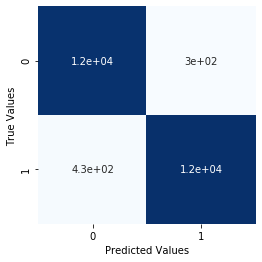



Testing Accuracy = 97.072%


              precision    recall  f1-score   support

           0       0.98      0.97      0.97     12500
           1       0.97      0.98      0.97     12500

    accuracy                           0.97     25000
   macro avg       0.97      0.97      0.97     25000
weighted avg       0.97      0.97      0.97     25000



In [67]:
# Set Figure
fig = plt.figure(figsize=(4,4)) 
pred_ = pred.argmax(axis=1)
y_test_oh_=y_test_oh.argmax(axis=1)
mat = confusion_matrix(y_test_oh_, pred_) # Confusion matrix

sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();
print('\n')

# Testing Accuracy
print("Testing Accuracy = {}%".format((mat.T[0][0]+mat.T[1][1])/250))
print('\n')
print(classification_report(y_test_oh_,pred_))

In [52]:
# Max Validation Accuracy
print('Max Validation Accuracy =',max(history.history['val_accuracy'])*100,'%')

Max Validation Accuracy = 88.13333511352539 %


In [53]:
model.save('Sentiment_Analysis.h5')